# CS1 Dataset Report


Import libraries, and print package versions.

In [1]:
import paramaterial as pam
from paramaterial import DataSet, DataItem, ModelSet
from paramaterial.models import ramberg
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

print('paramaterial', pam.__version__)
print('pandas', pd.__version__)
print('seaborn', sns.__version__)
print('matplotlib', mpl.__version__)

paramaterial 0.1.0
pandas 1.5.3
seaborn 0.12.2
matplotlib 3.7.0


### Gather data and info

Extract info from the filenames and make the info table.

In [2]:
info_lists = [[filename] + filename.split('_')[:4] for filename in os.listdir('data/01 raw data')]
info_table = pd.DataFrame(info_lists,
                          columns=['old_filename', 'test_type', 'temperature', 'lot', 'number']
                          ).sort_values(by='test_type', ascending=False)

Add a unique test ID column.

In [3]:
info_table['test_id'] = [f'test_ID_{i + 1:03d}' for i in range(len(info_table))]
info_table = info_table.set_index('test_id').reset_index()  # move the test_id column to the far left

Drop the PST tests. We are only going to be processing and analysing the uniaxial tests.

In [4]:
info_table['test_type'] = info_table['test_type'].replace('T', 'UT')
info_table['test_type'] = info_table['test_type'].replace('P', 'PST')
info_table = info_table[info_table['test_type'] != 'PST']
info_table = info_table[~info_table['lot'].isin(list('FGHI'))]

Add the information from the paper, and convert the temperatures to numbers.

In [5]:
info_table['rate'] = 8.66e-4  # units (/s) and all tests performed at same rate
info_table['A_0_(mm)'] = np.where(info_table['test_type'] == 'UT', 40.32, 20.16)
info_table['h_0_(mm)'] = 3.175
info_table['temperature'] = pd.to_numeric(info_table['temperature'])

### Format the data files.
In this example, the files are already in .csv format. We just check that the column headers are the same and that there are no duplicates, then rename the files by test id.

Check column headers, uniqueness.

In [6]:
pam.check_column_headers('data/01 raw data')
pam.check_for_duplicate_files('data/01 raw data')

Checking column headers...
First file headers:
	['Strain', 'Stress_MPa']
Headers in all files are the same as in the first file, except for None.
Checking for duplicate files...
No duplicate files found in "data/01 raw data".


Write the prepared data and rename the files by test id. Also write the prepared info table.

In [7]:
pam.copy_data_and_rename_by_test_id(data_in='data/01 raw data', data_out='data/01 prepared data',
                                    info_table=info_table)
info_table.to_excel('info/01 prepared info.xlsx', index=False)

Copied 76 files in data/01 raw data to data/01 prepared data.


### Make the experimental matrix
We want to identify useful groupings and make visualisations. The tests can be grouped by lot and temperature, with up to 3 repeated tests.

In [8]:
gold_cmap = mpl.colors.LinearSegmentedColormap.from_list("", ["white", (85 / 255, 49 / 255, 0)])
mpl.rcParams["axes.facecolor"] = gold_cmap(0.1)

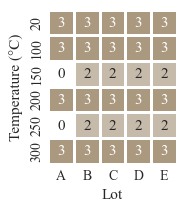

In [9]:
plt.figure(figsize=(2, 2))
pam.experimental_matrix(info_table, index='temperature', columns='lot', as_heatmap=True, cmap=gold_cmap, xlabel='Lot',
                        ylabel='Temperature (°C)', vmax=6);

### Visualise the prepared data.

We could colour by lot or by temperature. Colouring by lot is useful to observe variation, colouring by temperature is useful to observe temperature variation.

In [10]:
def make_strain_percent(di):
    di.data['Strain'] = di.data['Strain'] * 100
    return di


prepared_ds = DataSet('info/01 prepared info.xlsx', 'data/01 prepared data').sort_by(['temperature', 'lot']).apply(
    make_strain_percent)

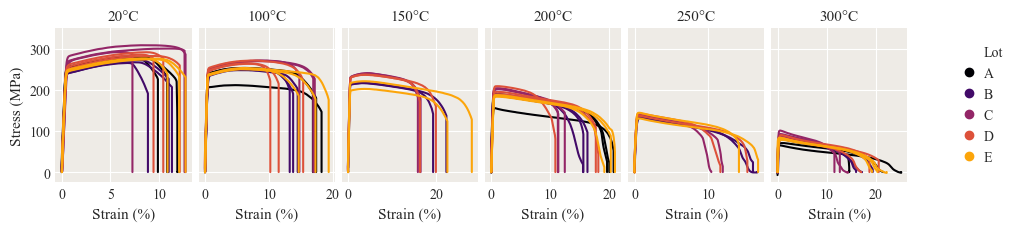

In [11]:
lot_styler = pam.Styler(color_by='lot', color_by_label='Lot', cmap='inferno').style_to(prepared_ds)


def ds_subplots(ds: DataSet, **kwargs):
    temperatures = sorted(prepared_ds.info_table['temperature'].unique())
    return pam.dataset_subplots(
        ds=ds, x='Strain', y='Stress_MPa', xlabel='Strain (%)', ylabel='Stress (MPa)',
        styler=lot_styler, plot_legend=False, figsize=(12, 2), shape=(1, 6), ylim=(-25., 350.),
        rows_by='test_type', cols_by='temperature', row_vals=[['UT']],
        col_vals=[[T] for T in temperatures], col_titles=[f'{T}°C' for T in temperatures],
        **kwargs)


ds_subplots(prepared_ds);

### Find UTS and Failure

In [12]:
def find_uts_and_failure(di: DataItem):
    di.info['UTS_1'] = di.data['Stress_MPa'].max()
    di.info['UTS_0'] = di.data['Strain'][di.data['Stress_MPa'].idxmax()]
    di.info['FP_0'] = di.data['Strain'].max()
    return di


prepared_ds = prepared_ds.apply(find_uts_and_failure)

### Trimming

In [13]:
def trim_to_small_strain(di: DataItem):
    di.data = di.data[di.data['Strain'] < 1]
    return di


trimmed_ds = prepared_ds.apply(trim_to_small_strain)

### Foot Correction

In [14]:
corrected_ds = pam.find_upl_and_lpl(trimmed_ds, preload=36, preload_key='Stress_MPa')
corrected_ds = pam.correct_foot(corrected_ds)

### Foot correction screening

Make screening pdf.

  0%|          | 0/1 [00:00<?, ?DataItems/s]
                                            
  0%|          | 0/1 [00:00<?, ?DataItems/s]
                                            
  0%|          | 0/1 [00:00<?, ?DataItems/s]
                                            
  0%|          | 0/1 [00:00<?, ?DataItems/s]
                                            
  0%|          | 0/1 [00:00<?, ?DataItems/s]
                                            
  0%|          | 0/1 [00:00<?, ?DataItems/s]
                                            
  0%|          | 0/1 [00:00<?, ?DataItems/s]
                                            
  0%|          | 0/1 [00:00<?, ?DataItems/s]
                                            
  0%|          | 0/1 [00:00<?, ?DataItems/s]
                                            
  0%|          | 0/1 [00:00<?, ?DataItems/s]
                                            
  0%|          | 0/1 [00:00<?, ?DataItems/s]
                                            
  0%|     

Screening pdf saved to info/foot correction screening.pdf.


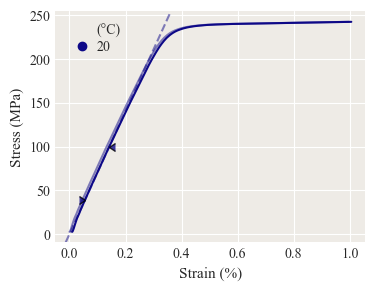

In [15]:
temp_styler = pam.Styler(color_by='temperature', color_by_label='(°C)').style_to(prepared_ds)


def ds_plot(ds: DataSet, **kwargs):
    return pam.dataset_plot(ds, x='Strain', y='Stress_MPa', xlabel='Strain (%)', ylabel='Stress (MPa)',
                            styler=temp_styler, **kwargs)


def foot_correction_screening_plot(di):
    test_id = di.test_id
    temp = di.info['temperature']
    color = temp_styler.color_dict[temp]
    UPL = (di.info['UPL_0'], di.info['UPL_1'])
    LPL = (di.info['LPL_0'], di.info['LPL_1'])
    _ax = ds_plot(corrected_ds.subset({'test_id': [test_id]}))
    _ax = ds_plot(trimmed_ds.subset({'test_id': [test_id]}), alpha=0.5, ax=_ax)
    _ax.axline(UPL, slope=di.info['E'], c=color, ls='--', alpha=0.5, zorder=500 + temp)
    _ax.plot(*UPL, c='k', mfc=color, marker=4, alpha=0.8, markersize=6, zorder=1000 + temp)
    _ax.plot(*LPL, c='k', mfc=color, marker=5, alpha=0.8, markersize=6, zorder=1000 + temp)


foot_correction_screening_plot(corrected_ds[3])
pam.make_screening_pdf(corrected_ds, foot_correction_screening_plot,
                       'info/foot correction screening.pdf');

Reject flagged tests.

In [16]:
rejected_ds = pam.read_screening_pdf(corrected_ds, 'info/foot correction screening marked.pdf')
rejected_items = rejected_ds.info_table[rejected_ds.info_table['reject'] == 'True']
rejected_items[['test_id', 'temperature', 'lot', 'number', 'reject', 'comment']]

,test_id,temperature,lot,number,reject,comment
38,test_ID_002,200,A,3,True,NaN
45,test_ID_015,200,C,2,True,NaN
48,test_ID_018,200,D,2,True,NaN
61,test_ID_041,300,A,2,True,NaN
71,test_ID_049,300,D,2,True,NaN


In [17]:
screened_ds = pam.remove_rejected_items(rejected_ds)

### Proof Stress

In [18]:
proof_ds = pam.find_proof_stress(ds=screened_ds, proof_strain=0.2)

In [19]:
proof_ds.write_output('info/02 processed info.xlsx', 'data/02 processed data')
processed_ds = DataSet('info/02 processed info.xlsx', 'data/02 processed data')

### Representative curves

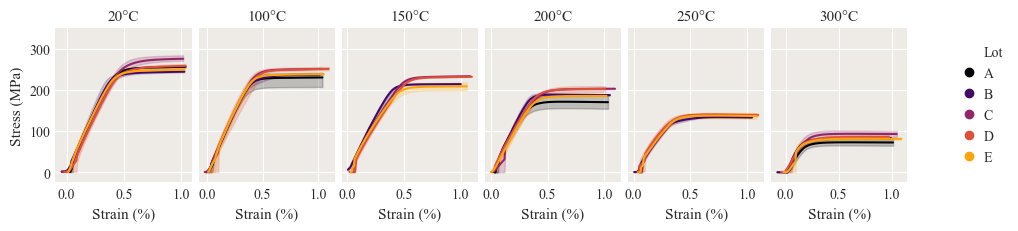

In [20]:
pam.make_representative_data(processed_ds, 'info/03 repres info.xlsx', 'data/03 repres data',
                             repres_col='Stress_MPa', group_by_keys=['lot', 'temperature', 'test_type'],
                             interp_by='Strain', group_info_cols=['E', 'PS_0.2_1', 'UTS_1', 'UTS_0', 'FP_0', 'UPL_1'])
repres_ds = DataSet('info/03 repres info.xlsx', 'data/03 repres data', test_id_key='repres_id')
ds_subplots(repres_ds, fill_between=('min_Stress_MPa', 'max_Stress_MPa'));

### Mechanical properties

In [21]:
table = pam.make_representative_info(processed_ds, group_by_keys=['temperature', 'test_type'],
                                     group_info_cols=['E', 'PS_0.2_1', 'UTS_1', 'UTS_0', 'FP_0', 'UPL_1'])
table[['temperature', 'nr averaged', 'E', 'PS_0.2_1', 'UTS_1', 'UTS_0', 'FP_0', 'std_PS_0.2_1', 'std_UTS_1',
       'std_UTS_0', 'std_FP_0']].style.hide(axis='index').format('{:.3g}').to_latex('info/04 mechanical properties.tex')

### Fitted curves

In [22]:
ramberg_ms = ModelSet(ramberg, param_names=['C', 'n'], var_names=['E', 'UPL_1'],
                      bounds=[(0., 1000.), (0.01, 0.8)], scipy_func='minimize')

ramberg_ms.fit_to(repres_ds, 'Strain', 'Stress_MPa', sample_size=40)

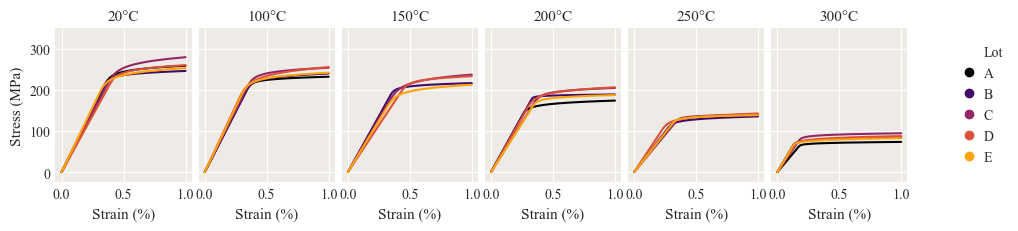

In [23]:
ramberg_ds = ramberg_ms.predict(xmin=0.0, xmax=1.0)
ds_subplots(ramberg_ds);

### Fitting results

In [24]:
ramberg_ds.info_table

,model_id,var_E,var_UPL_1,C,n,error,repres_id,lot,temperature,test_type,...,upstd_FP_0,downstd_FP_0,max_FP_0,min_FP_0,UPL_1,std_UPL_1,upstd_UPL_1,downstd_UPL_1,max_UPL_1,min_UPL_1
0,model_id_01,611.017082,157.503145,106.662284,0.089410,22.558510,repres_id_0001,A,20,UT,...,11.897337,9.867595,11.917776,9.889350,157.503145,41.468662,198.971806,116.034483,198.512982,115.590404
1,model_id_02,591.529680,169.863946,64.946765,0.082914,9.314522,repres_id_0002,A,100,UT,...,18.202901,16.834057,18.252270,16.897425,169.863946,19.647513,189.511459,150.216433,184.962353,147.650045
2,model_id_03,547.633583,102.789679,73.912053,0.094942,30.176575,repres_id_0004,A,200,UT,...,20.855684,19.811095,20.702707,19.964071,102.789679,44.615416,147.405094,58.174263,134.337542,71.241816
3,model_id_04,360.142237,54.358486,19.575776,0.117059,4.546511,repres_id_0006,A,300,UT,...,27.391182,12.439033,25.201491,14.628724,54.358486,3.637884,57.996370,50.720602,56.930859,51.786114
4,model_id_05,616.998577,168.508248,81.212860,0.086887,27.615398,repres_id_0007,B,20,UT,...,11.738586,9.057040,11.335128,8.862032,168.508248,60.027650,228.535898,108.480598,212.461145,100.116006
5,model_id_06,589.815424,157.980391,86.555217,0.102523,4.814263,repres_id_0008,B,100,UT,...,14.486030,13.231551,14.514066,13.263964,157.980391,12.769879,170.750270,145.210511,166.148394,143.264709
6,model_id_07,546.168752,126.735056,92.436279,0.056485,6.148400,repres_id_0009,B,150,UT,...,22.912655,18.646551,22.287899,19.271308,126.735056,0.575770,127.310827,126.159286,127.142187,126.327925
7,model_id_08,543.619050,143.062780,46.678311,0.040111,7.464027,repres_id_0010,B,200,UT,...,16.212487,15.377102,16.275938,15.525191,143.062780,14.131964,157.194744,128.930816,152.399410,126.804257
8,model_id_09,394.301365,92.182226,45.914655,0.136214,6.576198,repres_id_0011,B,250,UT,...,16.775987,15.983926,16.659992,16.099921,92.182226,3.682034,95.864260,88.500192,94.785818,89.578635
9,model_id_10,514.966624,50.797391,34.873667,0.125932,61.456758,repres_id_0012,B,300,UT,...,19.254916,15.818184,19.392554,16.000915,50.797391,6.850346,57.647737,43.947046,57.035151,43.466030


In [25]:
table = pam.make_representative_info(ramberg_ds, group_by_keys=['temperature', 'test_type'],
                                     group_info_cols=['E', 'UPL_1', 'C', 'n', 'error'])
table[['temperature', 'nr averaged', 'E', 'UPL_1', 'C', 'n', 'error']].style.hide(axis='index').format(
    '{:.3g}').to_latex('info/05 fitting results.tex')

In [26]:
processed_ds.info_table

,test_id,old_filename,test_type,temperature,lot,number,rate,A_0_(mm),h_0_(mm),UTS_1,...,UPL_0,UPL_1,LPL_0,LPL_1,E,foot correction,reject,comment,PS_0.2_0,PS_0.2_1
0,test_ID_080,T_020_A_1_001_022_03.csv,UT,20,A,1,0.000866,40.32,3.175,277.080919,...,0.248664,158.406047,0.116747,74.370735,637.027356,0.034361,False,NaN,0.595534,251.965967
1,test_ID_081,T_020_A_2_002_024_04.csv,UT,20,A,2,0.000866,40.32,3.175,277.834142,...,0.365280,198.512982,0.134887,73.304975,543.453841,0.048958,False,NaN,0.665334,252.887487
2,test_ID_082,T_020_A_3_003_025_05.csv,UT,20,A,3,0.000866,40.32,3.175,280.209188,...,0.177131,115.590404,0.055824,36.429261,652.570048,0.053076,False,NaN,0.589268,254.024472
3,test_ID_078,T_020_B_3_006_063_03.csv,UT,20,B,3,0.000866,40.32,3.175,265.627731,...,0.142267,100.116006,0.055657,39.166708,703.717033,0.009184,False,NaN,0.540802,239.827850
4,test_ID_083,T_020_B_1_004_059_01.csv,UT,20,B,1,0.000866,40.32,3.175,273.200296,...,0.322079,192.947594,0.063584,38.091190,599.068860,-0.044797,False,NaN,0.608213,244.547991
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66,test_ID_048,T_300_D_1_165_083_16.csv,UT,300,D,1,0.000866,40.32,3.175,80.759499,...,0.126864,54.103420,0.084542,36.054356,426.466827,-0.015518,False,NaN,0.387144,79.810507
67,test_ID_050,T_300_D_3_167_102_15.csv,UT,300,D,3,0.000866,40.32,3.175,90.107454,...,0.084519,43.086871,0.073556,37.497691,509.787185,-0.043036,False,NaN,0.370175,86.753265
68,test_ID_051,T_300_E_1_168_092_16.csv,UT,300,E,1,0.000866,40.32,3.175,81.978304,...,0.142772,59.721656,0.089440,37.413041,418.301492,-0.018112,False,NaN,0.392926,80.701222
69,test_ID_052,T_300_E_2_169_093_17.csv,UT,300,E,2,0.000866,40.32,3.175,83.615517,...,0.078102,54.068139,0.052153,36.104294,692.278201,0.091596,False,NaN,0.319719,82.878736


# MSC Thesis Figures

In [27]:
ramberg_ms_all = ModelSet(ramberg, param_names=['C', 'n'], var_names=['E', 'UPL_1'],
                      bounds=[(50., 200.), (0.05, 0.2)], scipy_func='minimize')
ramberg_ms_all.fit_to(processed_ds, 'Strain', 'Stress_MPa', sample_size=40)
ramberg_ds_all = ramberg_ms_all.predict(xmin=0, xmax=1.0)

df_1 = pam.make_representative_info(processed_ds, group_by_keys=['temperature', 'lot'],
                                    group_info_cols=['E', 'PS_0.2_1', 'UTS_1', 'UTS_0', 'UPL_1', 'UPL_0'])
df_2 = pam.make_representative_info(ramberg_ds_all, group_by_keys=['temperature', 'lot'],
                                    group_info_cols=['E', 'UPL_1', 'C', 'n', 'error'])

df = pd.concat([df_1, df_2[['C', 'std_C']]], axis=1)
df['E'] = df['E']/1000
df['max_E'] = df['max_E']/1000
df['min_E'] = df['min_E']/1000
df['std_E'] = df['std_E']/1000

## Figure 5.2

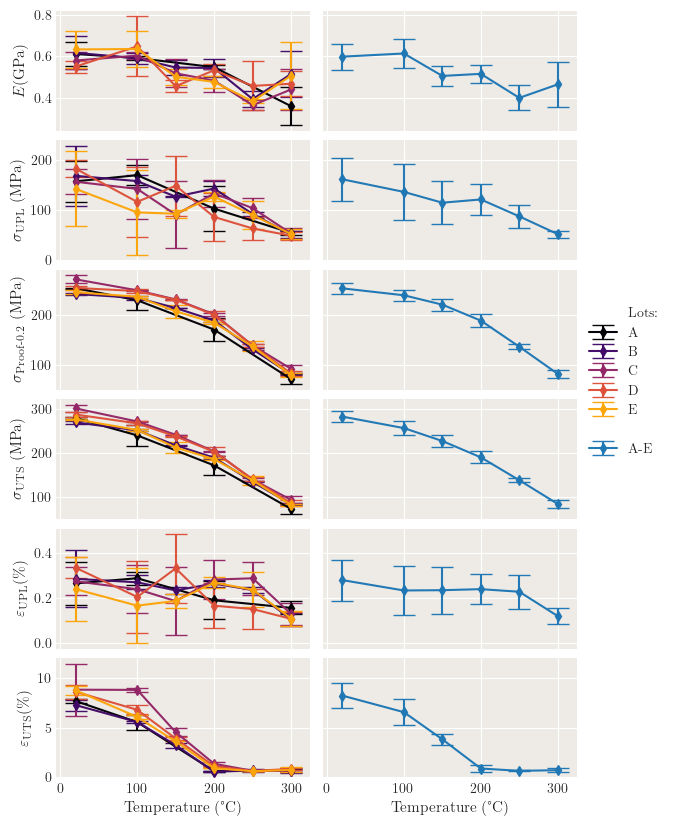

In [28]:
lots_df_1 = pam.make_representative_info(processed_ds,
                             group_by_keys=['temperature'],
                             group_info_cols=['E', 'PS_0.2_1', 'UTS_1', 'UTS_0', 'FP_0', 'UPL_1','UPL_0'])
lots_df_2 = pam.make_representative_info(ramberg_ds_all,
                                group_by_keys=['temperature'],
                                group_info_cols=['C', 'n'])

lots_df = pd.concat([lots_df_1, lots_df_2[['C', 'std_C']]], axis=1)
lots_df['E'] = lots_df['E']/1000
lots_df['max_E'] = lots_df['max_E']/1000
lots_df['min_E'] = lots_df['min_E']/1000
lots_df['std_E'] = lots_df['std_E']/1000

mpl.rcParams['text.usetex'] = True
fig, axs = plt.subplots(6, 2, figsize=(6., 8.4), sharex='all', sharey='row', gridspec_kw={'width_ratios': [1, 1]})
colors = [mpl.colormaps["inferno"](i) for i in np.linspace(0, 1, 6)]

axs_l = axs[:, 0].flat
for i, quant in enumerate(['E', 'UPL_1', 'PS_0.2_1', 'UTS_1', 'UPL_0','UTS_0']):
    data = df
    for j, material in enumerate('ABCDE'):
        mat_data = data[data['lot'] == material]
        axs_l[i].errorbar(mat_data['temperature'], mat_data[quant],
                        yerr=[mat_data['std_' + quant].values, mat_data['std_' + quant].values], label=material,
                        capsize=8, marker='d', markersize=5, color=colors[j], alpha=0.98)
        axs_l[i].set_xlim((-5, 325))

axs_r = axs[:, 1].flat
for i, quant in enumerate(['E', 'UPL_1', 'PS_0.2_1', 'UTS_1', 'UPL_0','UTS_0']):
    data = lots_df
    mat_data = data
    axs_r[i].errorbar(mat_data['temperature'], mat_data[quant],
                        yerr=[mat_data['std_' + quant].values, mat_data['std_' + quant].values], label='A-E',
                        capsize=8, marker='d', markersize=5, alpha=0.98)

axs_l[0].set(ylabel='$E$(GPa)')
axs_l[1].set(ylabel=r'$\sigma_{\text{UPL}}$ (MPa)')
axs_l[2].set(ylabel=r'$\sigma_{\text{Proof-0.2}}$ (MPa)')
axs_l[3].set(ylabel=r'$\sigma_{\text{UTS}}$ (MPa)')
axs_l[4].set(ylabel=r'$\varepsilon_{\text{UPL}} (\%)$')
axs_l[5].set(ylabel=r'$\varepsilon_{\text{UTS}} (\%)$')
axs_l[5].set(xlabel='Temperature (°C)')
axs_r[5].set(xlabel='Temperature (°C)')

handles = [mpl.patches.Patch(label='Lots:', alpha=0)] # + [mpl.patches.Patch(label='\t', alpha=0)]
handles = handles + axs_l[0].get_legend_handles_labels()[0] + [mpl.patches.Patch(label='\t', alpha=0)] + axs_r[0].get_legend_handles_labels()[0]
fig.legend(handles=handles, loc='upper center', ncol=1, bbox_to_anchor=(1.05, 0.64), markerfirst=True)

plt.tight_layout()
fig.subplots_adjust(wspace=0.05, hspace=0.08)

## Figure 5.3

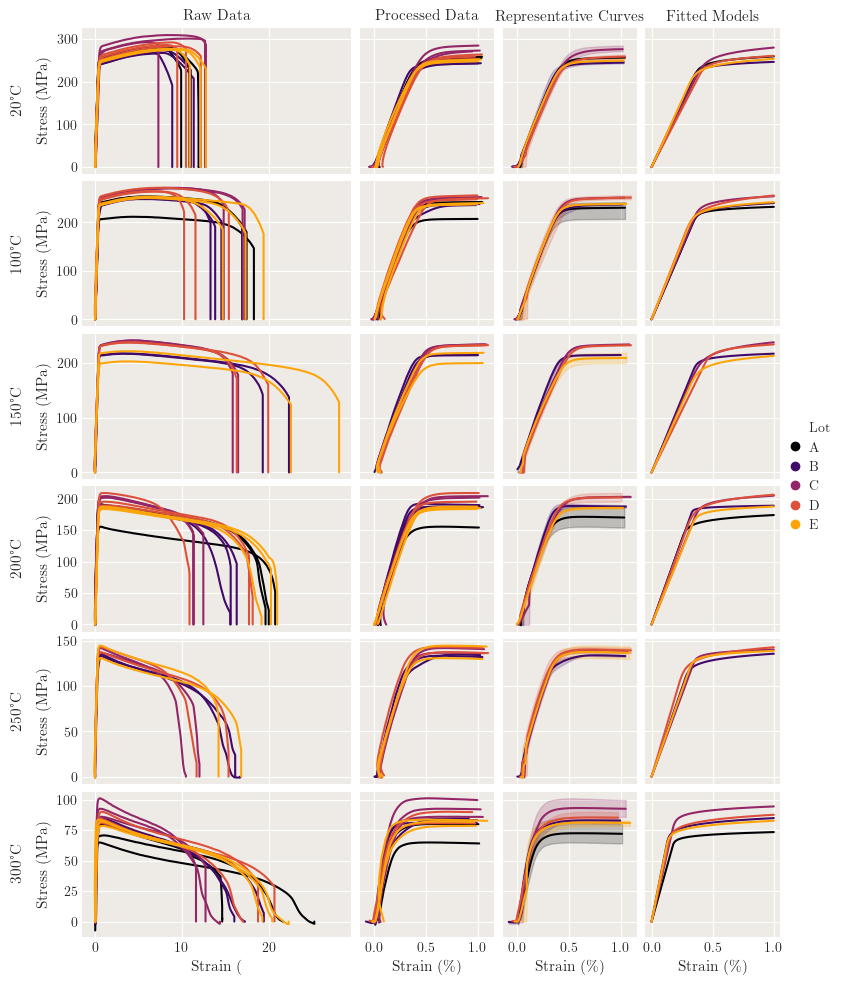

In [29]:
fig, axs = plt.subplots(6, 4, figsize=(9, 11.8), sharex='col', sharey='row', gridspec_kw={'width_ratios': [2, 1, 1, 1]})


def ds_subplots(ds: DataSet, **kwargs):
    temperatures = sorted(prepared_ds.info_table['temperature'].unique())
    mpl.rcParams["axes.facecolor"]= gold_cmap(0.1)
    return pam.dataset_subplots(ds=ds, x='Strain', y='Stress_MPa', xlabel='Strain (%)', ylabel='Stress (MPa)',
                                styler=lot_styler, plot_legend=False, figsize=(2, 12), shape=(6, 1),
                                cols_by='test_type', rows_by='temperature', col_vals=[['UT']],
                                row_vals=[[T] for T in temperatures], row_titles=[f'{T}°C' for T in temperatures],
                                subplot_legend=False,
                                **kwargs)


ds_subplots(prepared_ds, axs=axs[:, 0])


def ds_subplots(ds: DataSet, **kwargs):
    temperatures = sorted(prepared_ds.info_table['temperature'].unique())
    mpl.rcParams["axes.facecolor"]= gold_cmap(0.1)
    return pam.dataset_subplots(ds=ds, x='Strain', y='Stress_MPa', xlabel='Strain (\%)', ylabel='Stress (MPa)',
                                wspace=0.06, hspace=0.12,
                                styler=lot_styler, plot_legend=False, figsize=(2, 12), shape=(6, 1),
                                cols_by='test_type', rows_by='temperature', col_vals=[['UT']],
                                row_vals=[[T] for T in temperatures], subplot_legend=False,
                                **kwargs)


ds_subplots(processed_ds, axs=axs[:, 1])
ds_subplots(repres_ds, axs=axs[:, 2], fill_between=('min_Stress_MPa', 'max_Stress_MPa'))
ds_subplots(ramberg_ds, axs=axs[:, 3])

for ax, title in zip(axs[0, :].flat, ['Raw Data', 'Processed Data', 'Representative Curves', 'Fitted Models']):
    ax.set_title(title)

handles = lot_styler.legend_handles()
fig.subplots_adjust(wspace=0.05, hspace=0.05)
plt.subplots_adjust(right=0.9)
axs.flat[0].get_figure().legend(handles=handles, loc='center right',
                                bbox_to_anchor=(0.97, 0.5), handletextpad=0.05);

## Figure 5.4

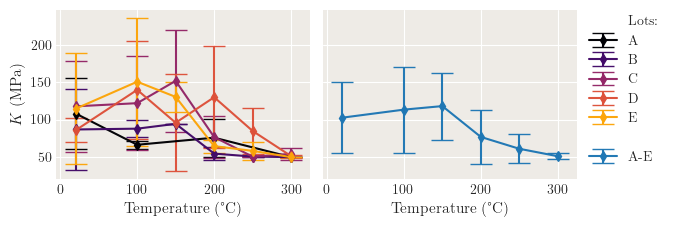

In [30]:
fig, axs = plt.subplots(1, 2, figsize=(6., 2.4), sharex='all', sharey='row', gridspec_kw={'width_ratios': [1, 1]})

axs_l = [axs[0]]
for i, quant in enumerate(['C']):
    data = df
    for j, material in enumerate('ABCDE'):
        mat_data = data[data['lot'] == material]
        axs_l[i].errorbar(mat_data['temperature'], mat_data[quant],
                        yerr=[mat_data['std_' + quant].values, mat_data['std_' + quant].values], label=material,
                        capsize=8, marker='d', markersize=5, color=colors[j], alpha=0.98)
        axs_l[i].set_xlim((-5, 325))

axs_r = [axs[1]]
for i, quant in enumerate(['C']):
    data = lots_df
    mat_data = data
    axs_r[i].errorbar(mat_data['temperature'], mat_data[quant],
                        yerr=[mat_data['std_' + quant].values, mat_data['std_' + quant].values], label='A-E',
                        capsize=8, marker='d', markersize=5, alpha=0.98)

axs[0].set(ylabel='$K$ (MPa)')
axs[0].set(xlabel='Temperature (°C)')
axs[1].set(xlabel='Temperature (°C)')

handles = [mpl.patches.Patch(label='Lots:', alpha=0)] 
handles = handles + axs[0].get_legend_handles_labels()[0] + [mpl.patches.Patch(label='\t', alpha=0)] + axs[1].get_legend_handles_labels()[0]
fig.legend(handles=handles, loc='upper center', ncol=1, bbox_to_anchor=(1.05, 0.96), markerfirst=True)

plt.tight_layout()
fig.subplots_adjust(wspace=0.05, hspace=0.08)